In [63]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np
from hessians_calc import *
from demo_parity_calc import *

In [64]:
df = pd.read_csv('compas-scores-two-years.csv')

In [65]:
df = df[['event', 'is_violent_recid', 'is_recid', 'priors_count', 'juv_other_count','juv_misd_count', 'juv_fel_count', 'race', 'age_cat', 'sex','score_text']]

In [66]:
def preprocess_compas(df):
    df['age_cat'] = df['age_cat'].map({'Less than 25': 0, '25 - 45': 1, 'Greater than 45': 2}).astype(int)    
    df['score_text'] = df['score_text'].map({'Low': 0, 'Medium': 1, 'High': 2}).astype(int)    
    df['race'] = df['race'].map({'Other': 0, 'African-American': 0, 'Hispanic': 0, 'Native American': 0, 'Asian': 0, 'Caucasian': 1}).astype(int)
    df['sex'] = df['sex'].map({'Male': 1, 'Female': 0}).astype(int)    
    
    df.loc[(df['priors_count'] <= 5), 'priors_count'] = 0
    df.loc[(df['priors_count'] > 5) & (df['priors_count'] <= 15), 'priors_count'] = 1
    df.loc[(df['priors_count'] > 15), 'priors_count'] = 2
    
    df.loc[(df['juv_fel_count'] == 0), 'juv_fel_count'] = 0
    df.loc[(df['juv_fel_count'] == 1), 'juv_fel_count'] = 1
    df.loc[(df['juv_fel_count'] > 1), 'juv_fel_count'] = 2
    
    df.loc[(df['juv_misd_count'] == 0), 'juv_misd_count'] = 0
    df.loc[(df['juv_misd_count'] == 1), 'juv_misd_count'] = 1
    df.loc[(df['juv_misd_count'] > 1), 'juv_misd_count'] = 2
    
    df.loc[(df['juv_other_count'] == 0), 'juv_other_count'] = 0
    df.loc[(df['juv_other_count'] == 1), 'juv_other_count'] = 1
    df.loc[(df['juv_other_count'] > 1), 'juv_other_count'] = 2
    return df

In [67]:
df = preprocess_compas(df)

In [68]:
filtered_df = df

In [69]:
df.shape[0]

7214

In [70]:
# df.rename(columns={'is_recid': 'not_recid'}, inplace=True)
# df['not_recid'] = 1-df['not_recid']

In [71]:
y = df['is_recid']

In [72]:
y.head()

0    0
1    1
2    1
3    0
4    0
Name: is_recid, dtype: int64

In [73]:
df = df.drop(columns=['is_violent_recid'])

In [74]:
df = df.drop(columns=['is_recid'])

In [75]:
df.size

64926

In [76]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [77]:
11542*0.8


9233.6

In [78]:
X_train.head()

,event,priors_count,juv_other_count,juv_misd_count,juv_fel_count,race,age_cat,sex,score_text
0,0,1,2,2,0,0,1,1,2
1,0,1,0,0,0,1,1,1,0
2,0,0,0,0,0,1,1,1,0
3,1,2,0,0,2,0,1,0,2
4,0,0,0,0,0,1,1,1,0


In [79]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)

In [80]:
X_train.size

51939

In [81]:
def demographic_parity(x_train_temp, y_train_temp, x_test_temp):
    # find the predictive probabilities for the protected and privileged groups based on 'age'
    # sc = StandardScaler()
    # x_test_scalar_temp = sc.fit_transform(x_test_temp)
    # x_train_scalar_temp = sc.fit_transform(x_train_temp)
    # y_train_scalar_temp = sc.fit_transform(y_train_temp)
    # clfl = eval(clf_name)(input_size=x_train_temp.shape[-1])
    # clfl.fit(x_train_scalar_temp, y_train_scalar_temp)

    # y_pred_proba_temp = clfl.predict_proba(x_test_scalar_temp)
    X_test_sc = sc.transform(x_test_temp)
    
    clf = LogisticRegression(input_size=X_train.shape[-1])

    clf.fit(x_train_temp, y_train_temp)

    y_pred_proba_temp = clf.predict_proba(X_test_sc)

    privileged_gp_indices = x_test_temp[x_test_temp['race'] == 1].index
    protected_gp_indices = x_test_temp[x_test_temp['race'] == 0].index  

    privileged_positive_pred = 0
    for x in range(len(privileged_gp_indices)):
        privileged_positive_pred += y_pred_proba_temp[privileged_gp_indices[x]]
    privileged_positive_pred /= len(privileged_gp_indices)

    protected_positive_pred = 0
    for x in range(len(protected_gp_indices)):
        protected_positive_pred += y_pred_proba_temp[protected_gp_indices[x]]
    protected_positive_pred /= len(protected_gp_indices)

    return  -(protected_positive_pred - privileged_positive_pred)

In [82]:
dp_ori = demographic_parity(X_train, y_train, X_test)

In [83]:
print(dp_ori)


-0.10664560881682311


In [84]:
x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)

In [85]:
x_train_ca = x_train_a
y_train_ca = y_train_a

In [86]:
# COVERAGE BASED ACQUISITION

def coverage_acqui(data_acqui_count, filtered_df, x_train_ca, y_train_ca):
    
       filtered_df_x = filtered_df[['event', 'priors_count', 'juv_other_count','juv_misd_count', 'juv_fel_count', 'race', 'age_cat', 'sex','score_text']]
       
       filtered_df_y = filtered_df[['is_recid']]
       filtered_df_y = sc.fit_transform(filtered_df_y)

       filtered_df_sc = sc.fit_transform(filtered_df_x)

       for i in range(data_acqui_count):
              index = i%len(filtered_df_x)
              x_train_ca = np.append(x_train_ca, [filtered_df_sc[index]], axis=0)
              y_train_ca = np.append(y_train_ca, [filtered_df_y[index]])


       # dp_ca = demographic_parity(x_train_ca, y_train_ca, X_test)
       print(len(x_train_ca))
       # print(dp_ca)
       return x_train_ca, y_train_ca
              

In [87]:
#for threshold = 10, 1 MUP = XXXXX1202, 2dp TBA
filtered_df_r1_a2_s0_s2 = filtered_df[(filtered_df['race'] == 1) & (filtered_df['age_cat'] == 2) & (filtered_df['sex'] == 0) & (filtered_df['score_text'] == 2)] 
x_train_ca, y_train_ca = coverage_acqui(2, filtered_df_r1_a2_s0_s2, x_train_ca, y_train_ca)


#for threshold = 50, 2 MUP = XXXXXX202, XXXXXX201, 30dp TBA, 11dp TBA
# filtered_df_a2_s0_s2 = filtered_df[(filtered_df['age_cat'] == 2) & (filtered_df['sex'] == 0) & (filtered_df['score_text'] == 2)] 
# x_train_ca, y_train_ca = coverage_acqui(30, filtered_df_a2_s0_s2, x_train_ca, y_train_ca)

# filtered_df_a2_s0_s1 = filtered_df[(filtered_df['age_cat'] == 2) & (filtered_df['sex'] == 0) & (filtered_df['score_text'] == 1)]
# x_train_ca, y_train_ca = coverage_acqui(11, filtered_df_a2_s0_s1, x_train_ca, y_train_ca)


# for threshold = 100, 4 MUP = XXXXXX202, XXXXXX201, XXXXXX002, XXXXXX000, 30dp TBA, 11dp TBA
# filtered_df_a2_s0_s2 = filtered_df[(filtered_df['age_cat'] == 2) & (filtered_df['sex'] == 0) & (filtered_df['score_text'] == 2)] 
# x_train_ca, y_train_ca = coverage_acqui(80, filtered_df_a2_s0_s2, x_train_ca, y_train_ca)

# filtered_df_a2_s0_s1 = filtered_df[(filtered_df['age_cat'] == 2) & (filtered_df['sex'] == 0) & (filtered_df['score_text'] == 1)]
# x_train_ca, y_train_ca = coverage_acqui(61, filtered_df_a2_s0_s1, x_train_ca, y_train_ca)

# filtered_df_a0_s0_s2 = filtered_df[(filtered_df['age_cat'] == 0) & (filtered_df['sex'] == 0) & (filtered_df['score_text'] == 2)] 
# x_train_ca, y_train_ca = coverage_acqui(35, filtered_df_a0_s0_s2, x_train_ca, y_train_ca)

# filtered_df_a0_s0_s0 = filtered_df[(filtered_df['age_cat'] == 0) & (filtered_df['sex'] == 0) & (filtered_df['score_text'] == 0)]
# x_train_ca, y_train_ca = coverage_acqui(13, filtered_df_a0_s0_s0, x_train_ca, y_train_ca)

# for threshold = 150, 1 MUP = XXXXXX2X2, 22dp TBA
# filtered_df_a2_s0_s2 = filtered_df[(filtered_df['age_cat'] == 2) & (filtered_df['score_text'] == 2)] 
# x_train_ca, y_train_ca = coverage_acqui(22, filtered_df_a2_s0_s2, x_train_ca, y_train_ca)

#  for threshold = 200, 1 MUP = XXXXXXX02, 10 dp TBA
# filtered_df_a2_s0_s2 = filtered_df[(filtered_df['sex'] == 0) & (filtered_df['score_text'] == 2)] 
# x_train_ca, y_train_ca = coverage_acqui(0, filtered_df_a2_s0_s2, x_train_ca, y_train_ca)


# for threshold = 500, 3MUPS = 'XXXXXXX02', 'XXXXXXX01'
# filtered_df_s0_s2 = filtered_df[(filtered_df['sex'] == 0) & (filtered_df['score_text'] == 2)] 
# x_train_ca, y_train_ca = coverage_acqui(310, filtered_df_s0_s2, x_train_ca, y_train_ca)

# filtered_df_s0_s1 = filtered_df[(filtered_df['sex'] == 0) & (filtered_df['score_text'] == 1)]
# x_train_ca, y_train_ca = coverage_acqui(99, filtered_df_s0_s1, x_train_ca, y_train_ca)


# for threshold = 1000, 3MUPS = 'XXXXXXX02', 'XXXXXXX01', 'XXXXXXX00'
# filtered_df_s0_s2 = filtered_df[(filtered_df['sex'] == 0) & (filtered_df['score_text'] == 2)] 
# x_train_ca, y_train_ca = coverage_acqui(810, filtered_df_s0_s2, x_train_ca, y_train_ca)

# filtered_df_s0_s1 = filtered_df[(filtered_df['sex'] == 0) & (filtered_df['score_text'] == 1)]
# x_train_ca, y_train_ca = coverage_acqui(599, filtered_df_s0_s1, x_train_ca, y_train_ca)

# filtered_df_s0_s0 = filtered_df[(filtered_df['sex'] == 0) & (filtered_df['score_text'] == 0)] 
# x_train_ca, y_train_ca = coverage_acqui(196, filtered_df_s0_s0, x_train_ca, y_train_ca)

dp_ca = demographic_parity(x_train_ca, y_train_ca, X_test)
print(dp_ca)


5773
-0.09256173886540692


In [88]:
# COVERAGE BASED ACQUISITION for one threshold - for comp plot

x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)

x_train_ca = x_train_a
y_train_ca = y_train_a

print(len(x_train_ca))
filtered_df_a2_s0_s2 = filtered_df[(filtered_df['sex'] == 0) & (filtered_df['score_text'] == 2)] 
dp = {}
counts_to_check = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
current_count = 0
    
filtered_df_x = filtered_df[['event', 'priors_count', 'juv_other_count','juv_misd_count', 'juv_fel_count', 'race', 'age_cat', 'sex','score_text']]

filtered_df_y = filtered_df[['is_recid']]
filtered_df_y = sc.fit_transform(filtered_df_y)

filtered_df_sc = sc.fit_transform(filtered_df_x)

for count in counts_to_check:
    target_count = counts_to_check[counts_to_check.index(count) + 1] - count if count != counts_to_check[-1] else counts_to_check[-1]
    while target_count > 0:
        index = current_count % len(filtered_df_x)
        x_train_ca = np.append(x_train_ca, [filtered_df_sc[index]], axis=0)
        y_train_ca = np.append(y_train_ca, [filtered_df_y[index]])
        current_count += 1
        target_count -= 1
        if current_count in counts_to_check:
            print(len(x_train_ca))
            dp[current_count] = demographic_parity(x_train_ca, y_train_ca, X_test)
            print(f"Demographic Parity for first {current_count} data points: {dp}")
        if current_count == max(counts_to_check):
            print(current_count)
            break

print(dp)
              

5771
6271
Demographic Parity for first 500 data points: {500: -0.11651895846554716}
6771
Demographic Parity for first 1000 data points: {500: -0.11651895846554716, 1000: -0.11390026728244534}
7271
Demographic Parity for first 1500 data points: {500: -0.11651895846554716, 1000: -0.11390026728244534, 1500: -0.12040064703198478}
7771
Demographic Parity for first 2000 data points: {500: -0.11651895846554716, 1000: -0.11390026728244534, 1500: -0.12040064703198478, 2000: -0.12100744466796276}
8271
Demographic Parity for first 2500 data points: {500: -0.11651895846554716, 1000: -0.11390026728244534, 1500: -0.12040064703198478, 2000: -0.12100744466796276, 2500: -0.12985282970351303}
8771
Demographic Parity for first 3000 data points: {500: -0.11651895846554716, 1000: -0.11390026728244534, 1500: -0.12040064703198478, 2000: -0.12100744466796276, 2500: -0.12985282970351303, 3000: -0.13326200074998812}
9271
Demographic Parity for first 3500 data points: {500: -0.11651895846554716, 1000: -0.1139002

In [93]:
#RANDOM DATA ACQUISITION
import random
count_to_check = 2 #for threshold 10
# count_to_check = 41 #for threshold = 50 
# count_to_check = 189 #for threshold = 100
# count_to_check = 22 #for threshold = 150
# count_to_check = 10 #for threshold = 200
# count_to_check = 1605 threshold = 1000
# count_to_check = 409 #threshold = 500

x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)

current_count = 0

for i in range(count_to_check):
    index =  random.randint(0, len(X_train) -1)
    x_train_a = np.append(x_train_a, [X_train[index]], axis=0)
    y_train_a = np.append(y_train_a, [y_train[index]])

dp_rand = demographic_parity(x_train_a, y_train_a, X_test)
print(f"Demographic Parity for {count_to_check} random data points: {dp_rand}")
print(len(x_train_a))

Demographic Parity for 2 random data points: -0.10664784751228518
5773


In [90]:
x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)

In [91]:
import random
import numpy as np

# Define the counts for which to calculate dp
counts_to_check = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]

x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)

current_count = 0
dp = {}

dp[0] = dp_ori

for count in range(1, max(counts_to_check) + 1):
    index = random.randint(0, len(X_train) - 1)
    x_train_a = np.append(x_train_a, [X_train[index]], axis=0)
    y_train_a = np.append(y_train_a, [y_train[index]])
    current_count += 1
    if current_count in counts_to_check:
        print(current_count)
        dp[current_count] = demographic_parity(x_train_a, y_train_a, X_test)
        print(f"Demographic Parity for first {current_count} data points: {dp[current_count]}")
    
    if current_count == max(counts_to_check):
        break

print(dp)


500
Demographic Parity for first 500 data points: -0.1086598664800818
1000
Demographic Parity for first 1000 data points: -0.11035362973155727
1500
Demographic Parity for first 1500 data points: -0.11058750138184004
2000
Demographic Parity for first 2000 data points: -0.11016048597610828
2500
Demographic Parity for first 2500 data points: -0.11153765554774331
3000
Demographic Parity for first 3000 data points: -0.11309600055066266
3500
Demographic Parity for first 3500 data points: -0.1131244719714849
4000
Demographic Parity for first 4000 data points: -0.1135163616736749
{0: -0.10664560881682311, 500: -0.1086598664800818, 1000: -0.11035362973155727, 1500: -0.11058750138184004, 2000: -0.11016048597610828, 2500: -0.11153765554774331, 3000: -0.11309600055066266, 3500: -0.1131244719714849, 4000: -0.1135163616736749}


In [92]:
x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)

result_plot = []
result = {}

for i in range(len(X_train)):
    x_train_new = np.append(x_train_a, [X_train[i]], axis=0)
    y_train_new = np.append(y_train_a, [y_train[i]])
    res = dp_ori - demographic_parity(x_train_new, y_train_new, X_test)
    result[i] = res
    result_plot.append(res)

# Sort the dictionary based on the values (res)
sorted_result = {k: v for k, v in sorted(result.items(), key=lambda item: item[1])}

KeyboardInterrupt: 

In [ ]:
# sorted_result = dict(sorted(result.items(), key=lambda item: item[1]))

In [ ]:
sorted_result = dict(sorted(result.items(), key=lambda item: -item[1]))

In [ ]:
#Define the counts for which to calculate dp
counts_to_check = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]

x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)

current_count = 0
dp = {}

dp[0] = dp_ori

for index, res in sorted_result.items():
    # print(index)
    x_train_a = np.append(x_train_a, [X_train[index]], axis=0)
    y_train_a = np.append(y_train_a, [y_train[index]])
    current_count += 1
    if current_count in counts_to_check:
        dp[current_count] = demographic_parity(x_train_a, y_train_a, X_test)
        print(f"Demographic Parity for first {current_count} data points: {dp}")
    
    if current_count == max(counts_to_check):
        break


Demographic Parity for first 500 data points: {0: -0.10664560881682311, 500: -0.16134202203470077}
Demographic Parity for first 1000 data points: {0: -0.10664560881682311, 500: -0.16134202203470077, 1000: -0.18540013435236813}
Demographic Parity for first 1500 data points: {0: -0.10664560881682311, 500: -0.16134202203470077, 1000: -0.18540013435236813, 1500: -0.19840840393235093}
Demographic Parity for first 2000 data points: {0: -0.10664560881682311, 500: -0.16134202203470077, 1000: -0.18540013435236813, 1500: -0.19840840393235093, 2000: -0.2078530551620631}
Demographic Parity for first 2500 data points: {0: -0.10664560881682311, 500: -0.16134202203470077, 1000: -0.18540013435236813, 1500: -0.19840840393235093, 2000: -0.2078530551620631, 2500: -0.21171070904829525}
Demographic Parity for first 3000 data points: {0: -0.10664560881682311, 500: -0.16134202203470077, 1000: -0.18540013435236813, 1500: -0.19840840393235093, 2000: -0.2078530551620631, 2500: -0.21171070904829525, 3000: -0.213

In [ ]:
X_train.size
X_test.size

12987

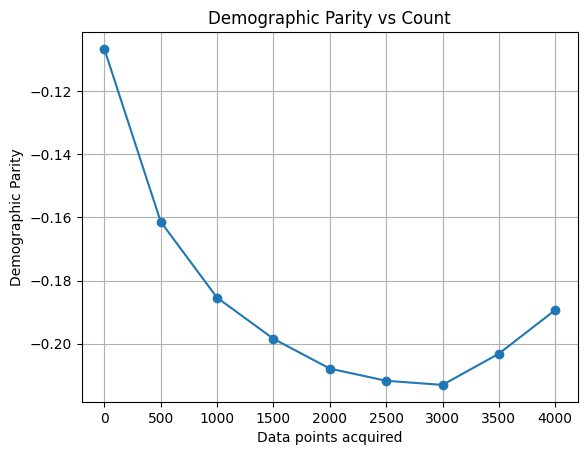

In [ ]:
import matplotlib.pyplot as plt

counts = list(dp.keys())
dp_values = list(dp.values())

# Plotting the dp values against the counts
plt.plot(counts, dp_values, marker='o')
plt.title('Demographic Parity vs Count')
plt.xlabel('Data points acquired')
plt.ylabel('Demographic Parity')
plt.grid(True)
plt.show()

In [ ]:
#Define the counts for which to calculate dp
counts_to_check = [2400, 2450, 2500, 2550, 2600]

x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)

current_count = 0
dp = {}

# dp[0] = dp_ori

for index, res in sorted_result.items():
    # print(index)
    x_train_a = np.append(x_train_a, [X_train[index]], axis=0)
    y_train_a = np.append(y_train_a, [y_train[index]])
    current_count += 1
    if current_count in counts_to_check:
        dp[current_count] = demographic_parity(x_train_a, y_train_a, X_test)
        print(f"Demographic Parity for first {current_count} data points: {dp}")
    
    if current_count == max(counts_to_check):
        break

Demographic Parity for first 2400 data points: {2400: -0.21125855094043128}
Demographic Parity for first 2450 data points: {2400: -0.21125855094043128, 2450: -0.2115021296887694}
Demographic Parity for first 2500 data points: {2400: -0.21125855094043128, 2450: -0.2115021296887694, 2500: -0.21171070904829525}
Demographic Parity for first 2550 data points: {2400: -0.21125855094043128, 2450: -0.2115021296887694, 2500: -0.21171070904829525, 2550: -0.21191816245476136}
Demographic Parity for first 2600 data points: {2400: -0.21125855094043128, 2450: -0.2115021296887694, 2500: -0.21171070904829525, 2550: -0.21191816245476136, 2600: -0.21213171615969906}


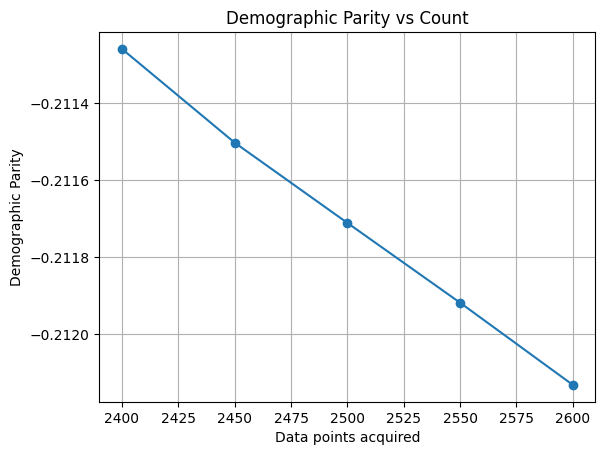

In [ ]:
import matplotlib.pyplot as plt

counts = list(dp.keys())
dp_values = list(dp.values())

# Plotting the dp values against the counts
plt.plot(counts, dp_values, marker='o')
plt.title('Demographic Parity vs Count')
plt.xlabel('Data points acquired')
plt.ylabel('Demographic Parity')
plt.grid(True)
plt.show()

In [ ]:
#Define the counts for which to calculate dp
counts_to_check = [2500, 2505, 2510, 2515, 2520, 2525, 2530, 2535, 2540, 2545, 2550]

x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)

current_count = 0
dp = {}

# dp[0] = dp_ori

for index, res in sorted_result.items():
    # print(index)
    x_train_a = np.append(x_train_a, [X_train[index]], axis=0)
    y_train_a = np.append(y_train_a, [y_train[index]])
    current_count += 1
    if current_count in counts_to_check:
        dp[current_count] = demographic_parity(x_train_a, y_train_a, X_test)
        print(f"Demographic Parity for first {current_count} data points: {dp}")
    
    if current_count == max(counts_to_check):
        break

Demographic Parity for first 2500 data points: {2500: -0.21171070904829525}
Demographic Parity for first 2505 data points: {2500: -0.21171070904829525, 2505: -0.21173117923879092}
Demographic Parity for first 2510 data points: {2500: -0.21171070904829525, 2505: -0.21173117923879092, 2510: -0.21175157872964978}
Demographic Parity for first 2515 data points: {2500: -0.21171070904829525, 2505: -0.21173117923879092, 2510: -0.21175157872964978, 2515: -0.2117719162292202}
Demographic Parity for first 2520 data points: {2500: -0.21171070904829525, 2505: -0.21173117923879092, 2510: -0.21175157872964978, 2515: -0.2117719162292202, 2520: -0.21179220233769414}
Demographic Parity for first 2525 data points: {2500: -0.21171070904829525, 2505: -0.21173117923879092, 2510: -0.21175157872964978, 2515: -0.2117719162292202, 2520: -0.21179220233769414, 2525: -0.21181240042395527}
Demographic Parity for first 2530 data points: {2500: -0.21171070904829525, 2505: -0.21173117923879092, 2510: -0.21175157872964

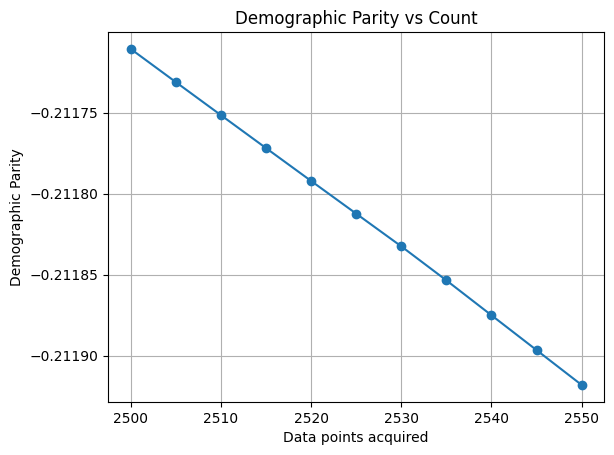

In [ ]:
import matplotlib.pyplot as plt

counts = list(dp.keys())
dp_values = list(dp.values())

# Plotting the dp values against the counts
plt.plot(counts, dp_values, marker='o')
plt.title('Demographic Parity vs Count')
plt.xlabel('Data points acquired')
plt.ylabel('Demographic Parity')
plt.grid(True)
plt.show()

In [ ]:
# number of data points to be acquired for minimizing the parity would be around 2530

In [ ]:
clf = eval('LogisticRegression')(input_size=X_train.shape[-1])
if isinstance(clf, LogisticRegression):
    loss_func = logistic_loss_torch


In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_test_scaler = sc.fit_transform(X_test)

In [ ]:
del_F_del_theta = del_spd_del_theta_com(clf, X_test, x_test_scaler, y_test)

In [ ]:
hessian_all_points = get_hessian_all_points(clf, X_train, y_train, loss_func)

100%|██████████| 5771/5771 [00:53<00:00, 108.65it/s]


In [ ]:
del_L_del_theta = get_del_L_del_theta(clf, X_train, y_train, loss_func)
print(type(del_L_del_theta))
print(del_L_del_theta.shape)

<class 'numpy.ndarray'>
(5771, 10)


In [ ]:
hinv_v, hinv = get_hinv_v(hessian_all_points, del_F_del_theta) 

In [ ]:
hinv_v, hinv = get_hinv_v(hessian_all_points, np.transpose(del_L_del_theta)) 

In [ ]:
#influence for each data point 
inf = np.matmul(np.transpose(hinv_v), del_F_del_theta)
inf = inf / 5771
print(inf.shape)

(5771,)


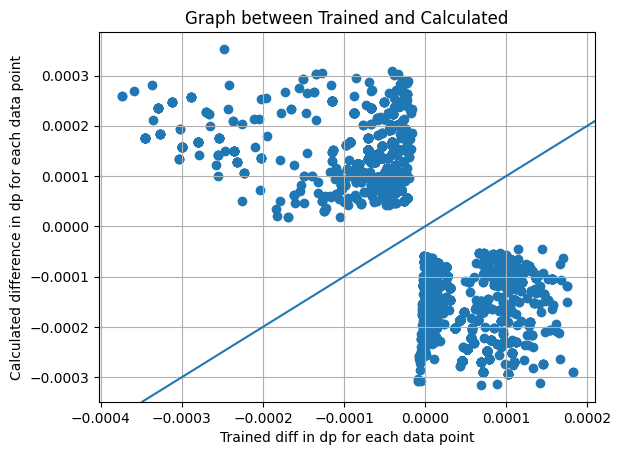

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
df = pd.DataFrame({'Trained': result_plot, 'Calculated': inf})
ax.scatter(df['Trained'], df['Calculated'], marker='o')
plt.title('Graph between Trained and Calculated')
plt.xlabel('Trained diff in dp for each data point')
plt.ylabel('Calculated difference in dp for each data point')
plt.grid(True)

ax.axline((0, 0), slope=1)
plt.show()


In [ ]:
inf_list = {index: value for index, value in enumerate(inf)}

In [ ]:
# INFLUENCE BASED SORTED DP FOR EACH DATA POINT
sorted_result_inf = {k: v for k, v in sorted(inf_list.items(), key=lambda item: -item[1])}

In [ ]:
counts_to_check = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]

x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)

current_count = 0
dp_inf = {}

dp_inf[0] = dp_ori

for index, res in sorted_result_inf.items():
    x_train_a = np.append(x_train_a, [X_train[index]], axis=0)
    y_train_a = np.append(y_train_a, [y_train[index]])
    current_count += 1
    if current_count in counts_to_check:
        dp_inf[current_count] = demographic_parity(x_train_a, y_train_a, X_test)
        print(f"Demographic Parity for first {current_count} data points: {dp_inf}")
    
    if current_count == max(counts_to_check):
        break

Demographic Parity for first 500 data points: {0: -0.10664560881682311, 500: -0.05834147121746314}
Demographic Parity for first 1000 data points: {0: -0.10664560881682311, 500: -0.05834147121746314, 1000: -0.036409987408318634}
Demographic Parity for first 1500 data points: {0: -0.10664560881682311, 500: -0.05834147121746314, 1000: -0.036409987408318634, 1500: -0.023351782404735066}
Demographic Parity for first 2000 data points: {0: -0.10664560881682311, 500: -0.05834147121746314, 1000: -0.036409987408318634, 1500: -0.023351782404735066, 2000: -0.011063002438075231}
Demographic Parity for first 2500 data points: {0: -0.10664560881682311, 500: -0.05834147121746314, 1000: -0.036409987408318634, 1500: -0.023351782404735066, 2000: -0.011063002438075231, 2500: -0.0039686454837507545}
Demographic Parity for first 3000 data points: {0: -0.10664560881682311, 500: -0.05834147121746314, 1000: -0.036409987408318634, 1500: -0.023351782404735066, 2000: -0.011063002438075231, 2500: -0.00396864548375

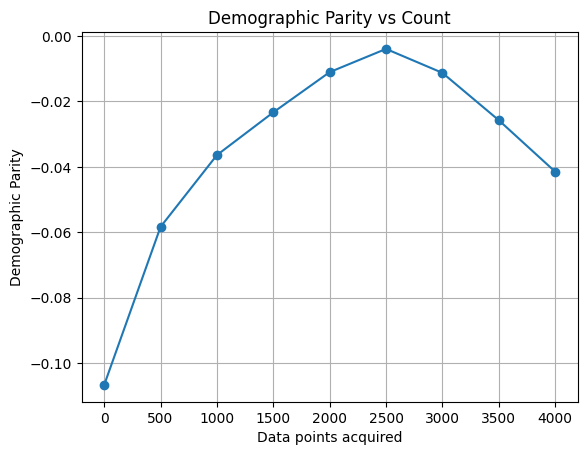

In [ ]:
import matplotlib.pyplot as plt

counts = list(dp_inf.keys())
dp_values_inf = list(dp_inf.values())

# Plotting the dp values against the counts
plt.plot(counts, dp_values_inf, marker='o')
plt.title('Demographic Parity vs Count')
plt.xlabel('Data points acquired')
plt.ylabel('Demographic Parity')
plt.grid(True)
plt.show()

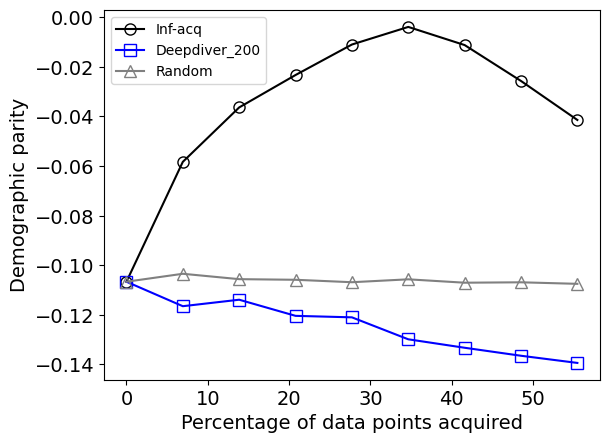

In [105]:
# Data for Influence based Data Acquisition calculating influence 
counts1 = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
counts1 = [x * 0.01386194 for x in counts1]
# counts_modified1 = [count / 8 for count in counts1]
dp_values1 = [-0.1066456, -0.05834147, -0.03640998, -0.023351, -0.0110630, -0.0039686, -0.011278, -0.0257499, -0.0414650] 


# Data for Coverage based Data Acquisition
counts2 = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
counts2 = [x * 0.01386194 for x in counts2]
dp_values2 = [-0.1066456, -0.11651, -0.11390, -0.12040, -0.12100, -0.129852, -0.13326, -0.13648, -0.13937]

# Data for Random Data Acquisition
counts3 = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
counts3 = [x * 0.01386194 for x in counts3]
dp_values3 = [-0.1066456, -0.1034437, -0.105614, -0.105865, -0.106849, -0.10568, -0.107044, -0.10688, -0.10750] 

# Plotting the dp values against the counts
plt.plot(counts1, dp_values1, marker='o', markerfacecolor='none', markersize=8, color='black',  label='Inf-acq')
plt.plot(counts2, dp_values2, marker='s',  markerfacecolor='none', markersize=8,color='blue', label='Deepdiver_200')
plt.plot(counts3, dp_values3, marker='^',  markerfacecolor='none', markersize=8, color='gray', label='Random')

# plt.title('Comparison of Data Acquisition Methods')
plt.xlabel('Percentage of data points acquired', fontsize=14)
plt.ylabel('Demographic parity', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=13)
plt.legend()  # Show legend with labels
plt.show()

In [ ]:
#2550 data points 

In [ ]:
# Influence based data acquisition for a particular number of data points

# count_to_check = 2 #for threshold 10
# count_to_check = 41 #for threshold = 50
# count_to_check = 189 #for threshold = 100
# count_to_check = 10 #for threshold = 200, 190 datapoints are already there
# count_to_check = 1605 for threshold = 1000
count_to_check = 2

x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)

count =0

for index, res in sorted_result_inf.items():
    # print(index)
    if count == count_to_check:
        break
    x_train_a = np.append(x_train_a, [X_train[index]], axis=0)
    y_train_a = np.append(y_train_a, [y_train[index]])
    count+=1
    
dp_ia = demographic_parity(x_train_a, y_train_a, X_test)
print(f"Demographic Parity for {count_to_check} data points: {dp_ia}") 


print(len(x_train_a)) 

Demographic Parity for 2 data points: -0.10639558893086254
5773


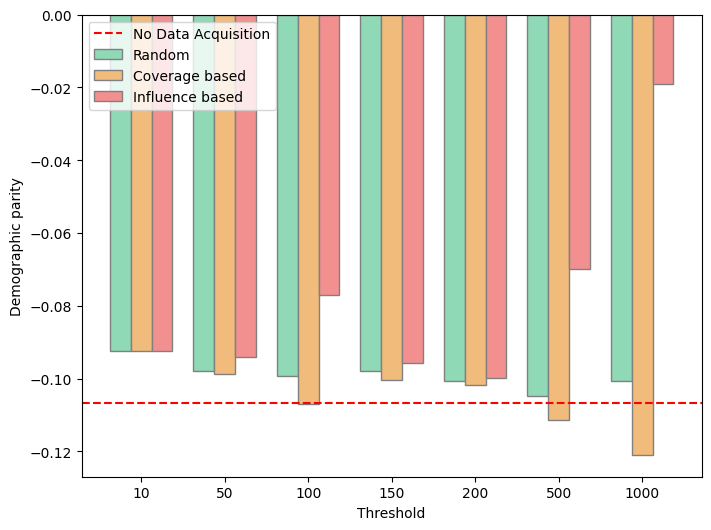

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data for each acquisition method
random_data = [[10, -0.10664], [50, -0.09795552], [100, -0.099281153], [150, -0.0979686], [200, -0.100579],[500, -0.104895865], [1000, -0.1008206]]  # for threshold 10, 2 data points are acquired, for threshold = 50, 41 data points are aacquired,  for threshold = 100, 189 data points are aacquired
coverage_based_data = [[10, -0.092561738], [50, -0.09865562], [100, -0.107089690], [150, -0.1005255], [200, -0.101671], [500, -0.11146433707986353], [1000, -0.1209484]]
influence_based_data = [[10, -0.106395], [50, -0.094008616], [100, -0.07703027], [150,-0.0955993], [200, -0.099825], [500, -0.0699143], [1000, -0.01906884]]

# Extracting x and y values for each method
threshold_random, dp_random = zip(*random_data)
threshold_coverage, dp_coverage = zip(*coverage_based_data)
threshold_influence, dp_influence = zip(*influence_based_data)

# Set width of bar
bar_width = 0.25

# Set position of bar on X axis
r1 = np.arange(len(threshold_random))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]



# Plotting the bars
plt.figure(figsize=(8, 6))  # Adjust figure size
plt.bar(r1, dp_random, color='#8fd9b6', width=bar_width, edgecolor='grey', label='Random')
plt.bar(r2, dp_coverage, color='#f1bb7b', width=bar_width, edgecolor='grey', label='Coverage based')
plt.bar(r3, dp_influence, color='#f28f8f', width=bar_width, edgecolor='grey', label='Influence based')

plt.axhline(y=-0.10664564, color='red', linestyle='--', label='No Data Acquisition')

# Adding labels and title
plt.xlabel('Threshold')
plt.ylabel('Demographic parity')
# plt.title('Comparison of Different Acquisition Methods')
plt.xticks([r + bar_width for r in range(len(threshold_random))], threshold_random)
plt.legend(loc='upper left')  # Adjust legend position

# Show plot
plt.show()


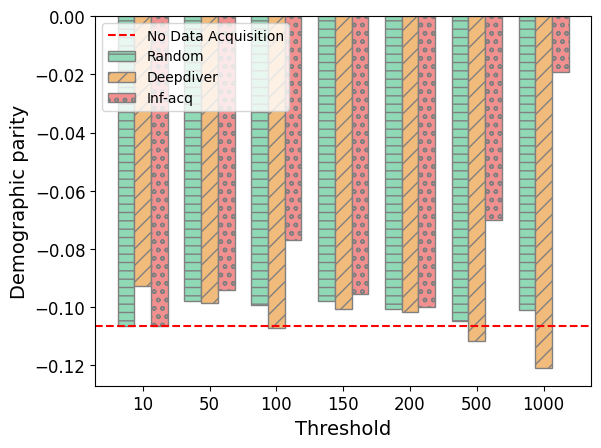

In [98]:
import numpy as np
import matplotlib.pyplot as plt

# Data for each acquisition method
random_data = [[10, -0.10664], [50, -0.09795552], [100, -0.099281153], [150, -0.0979686], [200, -0.100579], [500, -0.104895865], [1000, -0.1008206]]
coverage_based_data = [[10, -0.092561738], [50, -0.09865562], [100, -0.107089690], [150, -0.1005255], [200, -0.101671], [500, -0.11146433707986353], [1000, -0.1209484]]
influence_based_data = [[10, -0.106395], [50, -0.094008616], [100, -0.07703027], [150, -0.0955993], [200, -0.099825], [500, -0.0699143], [1000, -0.01906884]]

# Extracting x and y values for each method
threshold_random, dp_random = zip(*random_data)
threshold_coverage, dp_coverage = zip(*coverage_based_data)
threshold_influence, dp_influence = zip(*influence_based_data)

# Set width of bar
bar_width = 0.25

# Set position of bar on X axis
r1 = np.arange(len(threshold_random))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
 
plt.bar(r1, dp_random, color='#8fd9b6', width=bar_width, edgecolor='grey', label='Random', hatch='--')
plt.bar(r2, dp_coverage, color='#f1bb7b', width=bar_width, edgecolor='grey', label='Deepdiver', hatch='//')
plt.bar(r3, dp_influence, color='#f28f8f', width=bar_width, edgecolor='grey', label='Inf-acq', hatch='oo')

plt.axhline(y=-0.10664564, color='red', linestyle='--', label='No Data Acquisition')

plt.xlabel('Threshold',fontsize=14)
plt.ylabel('Demographic parity', fontsize=14)
plt.xticks([r + bar_width for r in range(len(threshold_random))], threshold_random,fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left') 

plt.show()
